# COVID-19 and Viral Pneumonia Detection Tool
### 1. Loading and Exploring Dataset

In [2]:
import os
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
data_path = pathlib.Path("/Users/Downloads/COVID_IEEE")  
assert data_path.exists(), "Dataset folder not found"

In [4]:
# === Count Images in Each Class ===
counts = {folder.name: len(list(folder.glob("*")))
          for folder in data_path.iterdir() if folder.is_dir()}

print("Number of images in each class:")
for label, count in counts.items():
    print(f"{label}: {count}")

Number of images in each class:
normal: 668
covid: 536
virus: 619


In [6]:
# === Create Data Frame ===
data = [(str(img), folder.name) for folder in data_path.iterdir() if folder.is_dir() for img in folder.glob("*")]
df = pd.DataFrame(data, columns=["filepath", "label"])

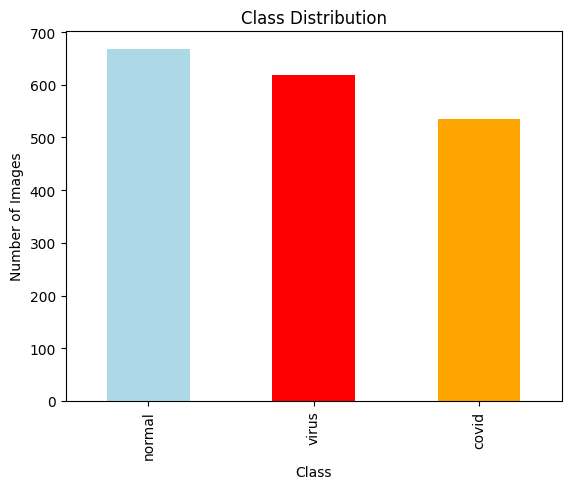

In [13]:
# ==== Class Distribution ===
df["label"].value_counts().plot(kind="bar", color=['lightblue','red','orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

Found 1708 files belonging to 3 classes.


2025-10-16 20:13:30.897672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


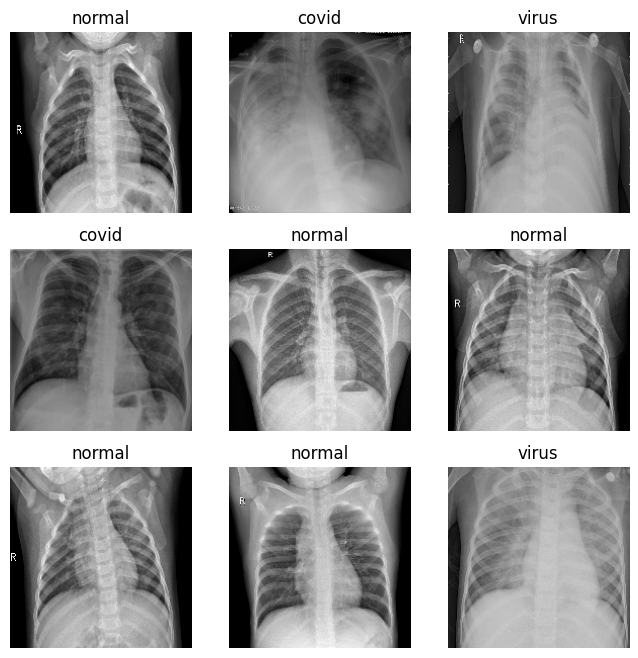

In [14]:
# === Load/Display Images ===
dataset = tf.keras.utils.image_dataset_from_directory(
    data_path,
    image_size=(180, 180),
    batch_size=9,
    shuffle=True
)

class_names = dataset.class_names
plt.figure(figsize=(8,8))
for images, labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

### 2. Build & Train Baseline CNN Model

### 3. Model Improvement

### 4. Evaluate Model Performances